<a href="https://colab.research.google.com/github/abiget/matrix-factorization-recommendation/blob/main/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time
import os

In [ ]:
def prepare_data_improved(ratings_df, num_test_items=5, random_state=42):
    """
    Prepare train and test datasets
    """
    np.random.seed(random_state)

    # Create rating matrix
    R = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(0).values

    # Initialize masks
    mask = R > 0
    train_mask = mask.copy()
    test_mask = np.zeros_like(mask)

    # For each user, select num_test_items highest-rated items for testing
    for u in range(R.shape[0]):
        user_ratings = np.where(mask[u])[0]
        if len(user_ratings) > num_test_items:
            # Sort by rating value
            user_ratings_sorted = user_ratings[np.argsort(-R[u, user_ratings])]
            # Select top-rated items for test
            test_indices = user_ratings_sorted[:num_test_items]
            train_mask[u, test_indices] = False
            test_mask[u, test_indices] = True

    # Create train and test matrices
    R_train = R.copy()
    R_train[~train_mask] = 0

    R_test = R.copy()
    R_test[~test_mask] = 0

    return R_train, R_test

In [ ]:
def prepare_data(ratings_df, test_size=0.2, random_state=42):
    """Prepare train and test datasets"""

    # np.random.seed(random_state)

    R = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(0).values

    # mask ratings
    mask = R != 0
    train_mask = mask.copy()
    test_mask = np.zeros_like(mask)

    # take test_size percent of each user to test set
    for u in range(R.shape[0]):
      user_ratings = np.where(mask[u])[0]

      if len(user_ratings) > 0:
        test_indices = np.random.choice(user_ratings, size=int(test_size*len(user_ratings)), replace=False)
        train_mask[u, test_indices] = False
        test_mask[u, test_indices] = True

    R_train = R.copy()
    R_train[~train_mask] = 0

    R_test = R.copy()
    R_test[~test_mask] = 0

    return R_train, R_test

In [ ]:
class MatrixFact:
  def __init__(self, latent_dim=12, epochs=1000, learning_rate=0.005, reg_param=0.12, momentum=0.5, verbos=True) -> None:
    self.latent_dim = latent_dim
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.reg_param = reg_param
    self.momentum = momentum
    self.best_factors = None
    self.history = dict(loss=[], train_rmse=[], test_rmse=[], lr=[])
    self.verbos = verbos

  def _init_factors(self, num_users, num_items):
    """Initialize factor matrices"""
    self.user_factors = np.random.normal(0, 0.001, (num_users, self.latent_dim))
    self.item_factors = np.random.normal(0, 0.001, (num_items, self.latent_dim))
    self.user_momentum = np.zeros_like(self.user_factors)
    self.item_momentum = np.zeros_like(self.item_factors)


  def fit(self, R_train, R_test):
    """Train the model"""
    self.num_users, self.num_items = R_train.shape
    self._init_factors(self.num_users, self.num_items)

    # training mask and indices
    train_mask = R_train != 0
    train_indices = np.argwhere(train_mask)

    #normalize train rating
    self.global_mean = np.mean(R_train[train_mask])
    R_norm = R_train.copy()
    R_norm[train_mask] = (R_train[train_mask] - self.global_mean)

    best_test_rmse = float('inf')
    patience = 5
    patience_counter = 0
    decay = 25

    # def get_lr(step, initial_lr, warmup=5, decay_factor=0.1):
    #   if step < warmup:
    #     return initial_lr * ((step + 1) / warmup)
    #   return initial_lr * (decay_factor ** (step / decay))

    for step in range(self.epochs):
      total_error = 0
      np.random.shuffle(train_indices)
      current_lr = self.learning_rate / (1 + step / decay)
      # current_lr = self.learning_rate * (0.1 + 0.9 / (1 + step / decay))
      # current_lr = get_lr(step, self.learning_rate)

      for u, i in train_indices:
        pred = np.dot(self.user_factors[u, :], self.item_factors[i, :])
        err = R_norm[u, i] - pred

        user_grad = err * self.item_factors[i, :] - self.reg_param * self.user_factors[u, :]
        item_grad = err * self.user_factors[u, :] - self.reg_param * self.item_factors[i, :]

        self.user_momentum[u, :] = self.momentum * self.user_momentum[u, :] + current_lr * user_grad
        self.item_momentum[i, :] = self.momentum * self.item_momentum[i, :] + current_lr * item_grad

        self.user_factors[u, :] += self.user_momentum[u, :]
        self.item_factors[i, :] += self.item_momentum[i, :]

        total_error += err ** 2 + self.reg_param * (np.sum(self.user_factors[u, :] ** 2) + np.sum(self.item_factors[i, :] ** 2))

      if step % 2 == 0:
        train_rmse = self.calculate_rmse(R_train)
        test_rmse = self.calculate_rmse(R_test)
        self.history['loss'].append(total_error)
        self.history['train_rmse'].append(train_rmse)
        self.history['test_rmse'].append(test_rmse)
        self.history['lr'].append(current_lr)

        print('here!!!!!!!!!!!!!')
        if self.verbos:
          print(f"Epoch: {step},\t Loss: {total_error :.4f},\t Train RMSE: {train_rmse :.4f},\
          Test RMSE: {test_rmse :.4f}, Diff: {(test_rmse - train_rmse) :.5f}, LR: {current_lr :.6f}")

        #check early stoping
        if test_rmse < best_test_rmse:
          best_test_rmse = test_rmse
          self.best_factors = (self.user_factors.copy(), self.item_factors.copy())
          patience_counter = 0
        else:
          patience_counter += 1

        if patience_counter >= patience:
          print(f"\nEarly stopping at step {step}")
          break

  def predict_all(self):
    """Predict all ratings"""
    predictions = np.dot(self.user_factors, self.item_factors.T)
    return np.clip((predictions + self.global_mean), 0.5, 5)

  def predict(self, user_idx, item_idx):
    """Predict rating for a specific user-item pair"""
    prediction = np.dot(self.user_factors[user_idx, :], self.item_factors[item_idx, :])
    return np.clip((prediction + self.global_mean), 0.5, 5)

  def calculate_rmse(self, R):
    """Calculate RMSE for given ratings matrix"""
    mask = R != 0
    predictions = self.predict_all()
    return np.sqrt(np.mean((R[mask] - predictions[mask])**2))


In [ ]:
class MatrixFactParallel(MatrixFact):

    # init parameters
    def __init__(self, latent_dim, epochs, learning_rate, reg_param, momentum, verbos):
        super().__init__(latent_dim, epochs, learning_rate, reg_param, momentum, verbos)


    def fit(self, R_train, R_test):
        """Train the model using vectorized operations"""
        self.num_users, self.num_items = R_train.shape
        self._init_factors(self.num_users, self.num_items)

        # training mask and indices
        train_mask = R_train > 0

        # normalize train rating
        self.global_mean = np.mean(R_train[train_mask])
        R_norm = R_train.copy()
        R_norm[train_mask] = (R_train[train_mask] - self.global_mean)

        best_test_rmse = float('inf')
        patience = 5
        patience_counter = 0
        decay = 25

        for step in range(self.epochs):
            current_lr = self.learning_rate / (1 + step / decay)

            # Compute all predictions at once
            predictions = np.dot(self.user_factors, self.item_factors.T)
            errors = np.zeros_like(R_train)
            errors[train_mask] = R_norm[train_mask] - predictions[train_mask]

            # Compute gradients
            user_grads = np.dot(errors, self.item_factors) - self.reg_param * self.user_factors
            item_grads = np.dot(errors.T, self.user_factors) - self.reg_param * self.item_factors

            # Update momentum
            self.user_momentum = self.momentum * self.user_momentum + current_lr * user_grads
            self.item_momentum = self.momentum * self.item_momentum + current_lr * item_grads

            # Update factors
            self.user_factors += self.user_momentum
            self.item_factors += self.item_momentum

            # Calculate total error
            total_error = np.sum(errors[train_mask] ** 2) + \
                         self.reg_param * (np.sum(self.user_factors ** 2) + np.sum(self.item_factors ** 2))

            if step % 2 == 0:
                train_rmse = self.calculate_rmse(R_train)
                test_rmse = self.calculate_rmse(R_test)
                self.history['loss'].append(total_error)
                self.history['train_rmse'].append(train_rmse)
                self.history['test_rmse'].append(test_rmse)
                self.history['lr'].append(current_lr)

                if self.verbos:
                  print(f"Epoch: {step},\t Loss: {total_error :.4f},\t Train RMSE: {train_rmse :.4f},\
                    Test RMSE: {test_rmse :.4f}, Diff: {test_rmse - train_rmse :.6f} LR: {current_lr :.6f}")

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                    self.best_factors = (self.user_factors.copy(), self.item_factors.copy())
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"\nEarly stopping at step {step}")
                    break

In [ ]:
def start_training(
      ratings_df,
      prepare_improved=False,
      epochs=300,
      learning_rate=0.003,
      latent_dim=12,
      reg_param=0.12,
      momentum=0.5,
      parallel=True,
      verbos=True
    ):
  #prepare data
  if prepare_improved:
    R_train, R_test = prepare_data_improved(ratings_df)
  else:
    R_train, R_test = prepare_data(ratings_df)

  # time start
  start = time.time()
  if parallel:
    mf = MatrixFactParallel(latent_dim, epochs, learning_rate, reg_param, momentum, verbos)
  else:
    mf = MatrixFact(latent_dim, epochs, learning_rate, reg_param, verbos)

  mf.fit(R_train, R_test)
  print(f"Time taken: {((time.time() - start) / 60)  :5f}  min")
  return mf, R_train, R_test

In [ ]:
#init current working dir
%cd /content/drive/MyDrive/Data_Mining/Project/

/content/drive/MyDrive/Data_Mining/Project


In [ ]:
!pwd

/content/drive/MyDrive/Data_Mining/Project


In [ ]:
# data_path = 'data/ml-100k/ratings.csv'
#read file
# data_path = 'data/ml-10M100K/ratings.dat'
data_path = 'data/ml-1m/ratings.dat'
# ratings_df = pd.read_csv(data_path)

ratings_df = pd.read_csv(
    data_path, sep='#', engine='python',
    names=['userId', 'movieId', 'rating', "timestamp"]
)

ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
# start training
mf, R_train, R_test = start_training(
    ratings_df,
    epochs=500,
    learning_rate=0.005,
    latent_dim=12,
    reg_param=0.12,
    momentum=0.5,
    verbos=False
  )


Early stopping at step 52
Time taken: 0.795617  min


In [ ]:
def final_rmses(mat_fact, train_data, test_data):
  # Get final predictions
  predictions = mat_fact.predict_all()

  # Calculate final metrics
  final_train_rmse = mat_fact.calculate_rmse(train_data)
  final_test_rmse = mat_fact.calculate_rmse(test_data)
  print(f"\nFinal Results:")
  print(f"Train RMSE: {final_train_rmse:.4f}")
  print(f"Test RMSE: {final_test_rmse:.4f}")
  print(f"Diff RMSE: {final_test_rmse - final_train_rmse :.4f}")
  return predictions, final_train_rmse, final_test_rmse

predictions,_,_ = final_rmses(mf, R_train, R_test)


Final Results:
Train RMSE: 0.7649
Test RMSE: 0.8630
Diff RMSE: 0.0981


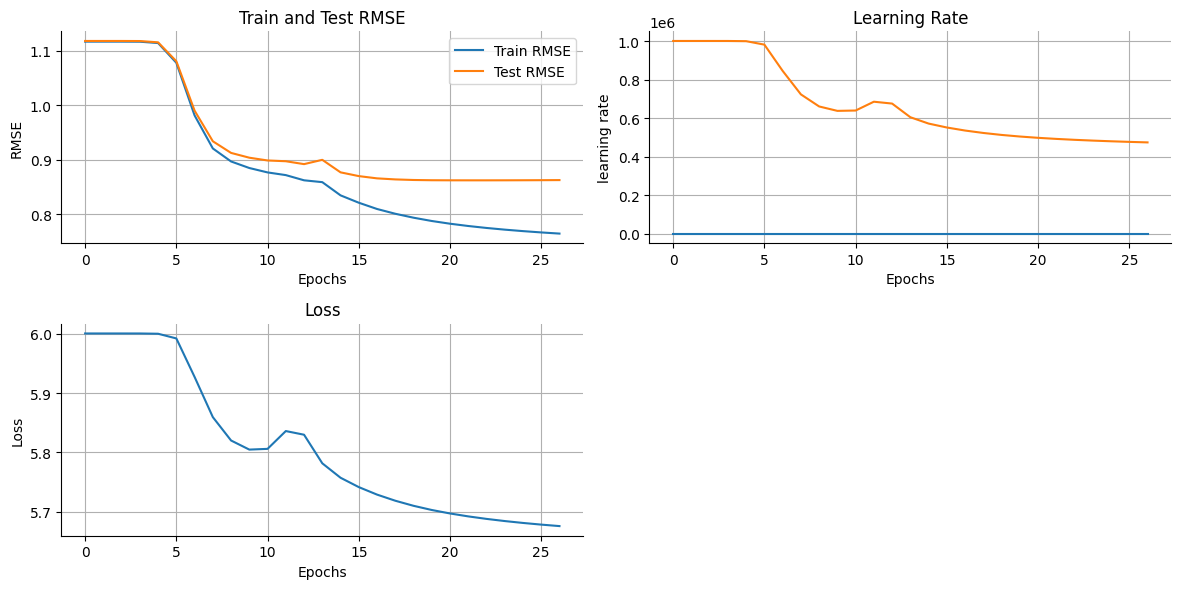

In [ ]:
from calculate_rank_metrics import evaluate_complete, print_evaluation_results
from plot_results import plot_train_progress, plot_rank_metric
# plot train and test progrss
plot_train_progress(mf.history)


Evaluation Results:
--------------------------------------------------

Metrics for top_5:
HR@N: 0.2866
NDCG@N: 0.0250
MRR: 0.1472

Metrics for top_10:
HR@N: 0.4253
NDCG@N: 0.0356
MRR: 0.1656

Metrics for top_20:
HR@N: 0.5803
NDCG@N: 0.0499
MRR: 0.1764

Metrics for top_50:
HR@N: 0.7470
NDCG@N: 0.0757
MRR: 0.1818

Metrics for top_100:
HR@N: 0.8406
NDCG@N: 0.1012
MRR: 0.1832


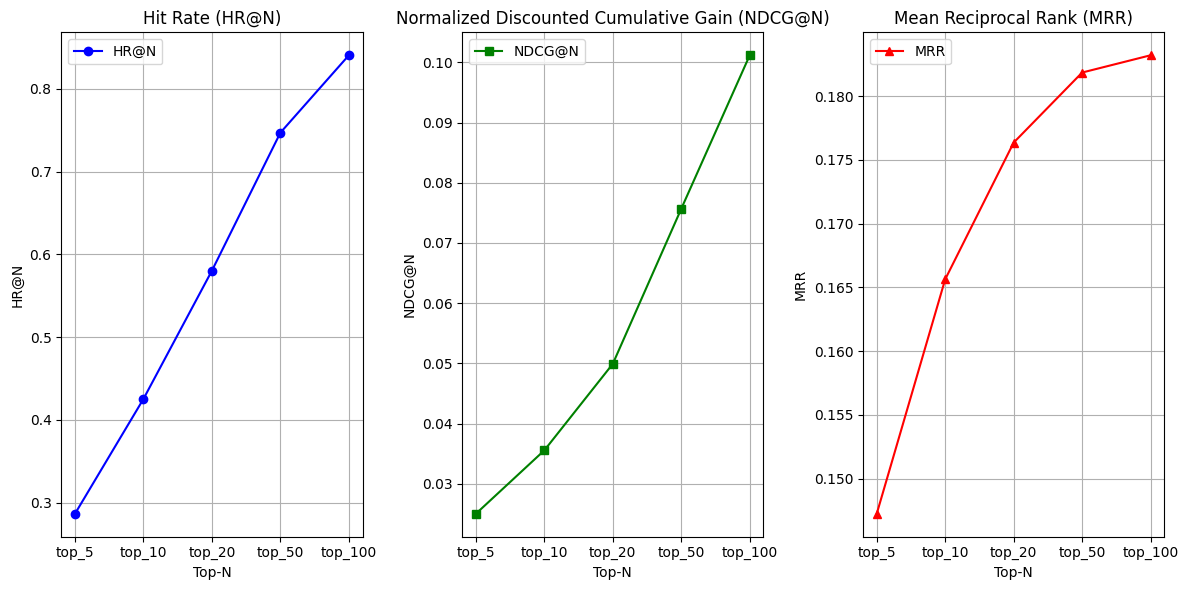

In [ ]:
# print and plot rank metrics
test_results = evaluate_complete(R_test, mf.predict_all())
print_evaluation_results(test_results)
plot_rank_metric(test_results)

#### Demo

In [ ]:
predictions_df = pd.DataFrame(predictions,
                              columns=ratings_df['movieId'].unique(),
                              index=ratings_df['userId'].unique())

# Reset index to have 'userId' as a column
user_preds_df = predictions_df.reset_index().melt(id_vars="index", var_name="movieId", value_name="rating")

# Rename 'index' to 'userId'
user_preds_df.rename(columns={"index": "userId"}, inplace=True)
user_preds_df.head()

,userId,movieId,rating
0,1,1193,4.150257
1,2,1193,4.095182
2,3,1193,4.050802
3,4,1193,4.268386
4,5,1193,3.637878


GPU Implementation
